In [1]:
%run ./modules.ipynb
sns.set(style="white", palette="muted", color_codes=True)
my_c=colors.ListedColormap(["mediumblue", 'red'])
c= ["mediumblue", 'red']
sns.set_palette(sns.color_palette(c))

LOADING FORMATION ENERGIES

In [2]:
df = load_dataset("mp_all_20181018")

compression_opts = dict(method='zip',
                        archive_name='example_MP.csv')  

df.to_csv('example_MP.zip', index=False,
          compression=compression_opts) 


/home/egazzarrini/miniconda3/envs/aiida/lib/python3.8/site-packages/pymatgen/core/periodic_table.py:203: UserWarning: No electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/egazzarrini/miniconda3/envs/aiida/lib/python3.8/site-packages/pymatgen/core/periodic_table.py:203: UserWarning: No electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/egazzarrini/miniconda3/envs/aiida/lib/python3.8/site-packages/pymatgen/core/periodic_table.py:203: UserWarning: No electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


In [3]:
zf = zipfile.ZipFile('./example_MP.zip') 
df_csv = pd.read_csv(zf.open('example_MP.csv'))

In [4]:
#reduced data
df=df_csv[::100]
len(df)

840

In [5]:
npzfile = np.load("./example_SOAP_MP.npz", allow_pickle=True)
for k in npzfile.files:
    print(k)
df['magic']=npzfile['magic']

idx
my_frames
magic
X_raw
coeff


Text(0.5, 0, 'Formation Energy per atom (eV)')

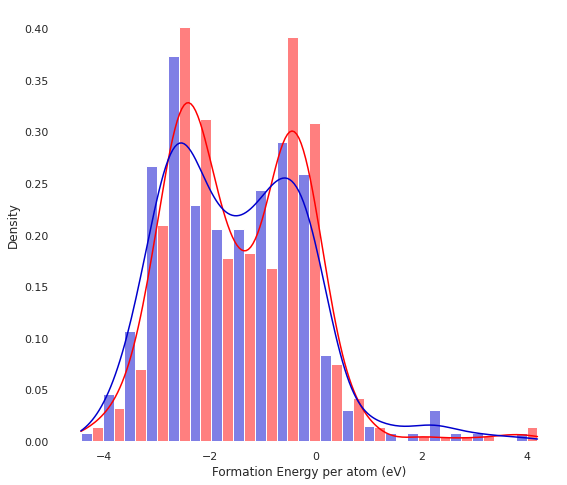

In [6]:
f, ax = plt.subplots(figsize=(9,8))
sns.histplot(data=df, x='e_form', hue='magic', multiple='dodge', 
             legend=False, common_norm=False, stat='density', kde=True)
sns.despine(left=True, bottom=True)
plt.xlabel('Formation Energy per atom (eV)')

In [7]:
X_raw=npzfile['X_raw']
y_raw=y_raw = np.array(df["e_form"]).reshape(-1, 1)
y_atom=npzfile['magic']
my_frames=npzfile['my_frames']

PRINCIPAL COVARIATES REGRESSION (PCovR) REPRESENTATION

In [23]:
i_train, i_test, X_train, X_test, y_train, y_test = train_test_split(
    np.arange(X_raw.shape[0]), X_raw, y_raw, train_size=0.8
)
print(f'Shape of testing data is: {X_train.shape}, ||X|| = {np.linalg.norm(X_train)}.')
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

print(
    "Norm of the features: %0.2f \nNorm of the targets: %0.2f"
    % (np.linalg.norm(X_raw), np.linalg.norm(y_raw))
)
x_scaler = StandardFlexibleScaler(column_wise=False).fit(X_raw)
y_scaler = StandardFlexibleScaler(column_wise=True).fit(y_raw)

# Center total dataset
X = x_scaler.transform(X_raw)
Y = y_scaler.transform(y_raw)

# Center training data
X_train = x_scaler.transform(X_train)
y_train = y_scaler.transform(y_train)

# Center training data
X_test = x_scaler.transform(X_test)
y_test = y_scaler.transform(y_test)

print("After normalization: ")
print(f'Shape of testing data is: {X_train.shape}, ||X|| = {np.linalg.norm(X_train)}.')
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

print(
    "Norm of the features: %0.2f \nNorm of the targets: %0.2f"
    % (np.linalg.norm(X_raw), np.linalg.norm(y_raw))
)

Shape of testing data is: (672, 2000), ||X|| = 0.06663686939389993.
(672, 2000) (168, 2000) (672, 1) (168, 1)
Norm of the features: 0.08 
Norm of the targets: 56.70
After normalization: 
Shape of testing data is: (672, 2000), ||X|| = 22.547980255690465.
(672, 2000) (168, 2000) (672, 1) (168, 1)
Norm of the features: 0.08 
Norm of the targets: 56.70


GRID CV REGRESSION

R^2 of training is  0.1729739078026209
R^2 of testing is  -0.12210551794301994
Best regularization is  1.0
RMSE on predicted quantity =  1.238369645383359


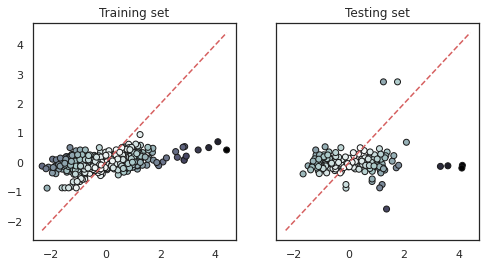

In [24]:
alphas=np.logspace(-0, -6, 30)
ridgecv = RidgeCV(cv=4,fit_intercept=False, alphas=alphas)
ridgecv.fit(X_train, y_train)
yp_test=ridgecv.predict(X_test)
yp_train=ridgecv.predict(X_train)
print('R^2 of training is ', ridgecv.score(X_train,y_train))
print('R^2 of testing is ', ridgecv.score(X_test,y_test))
print('Best regularization is ', ridgecv.alpha_)
fig, (ax_train, ax_test)=plt.subplots(1,2,figsize=(8,4), sharex=True, sharey=True)
ax_train.scatter(y_train, yp_train, c=np.abs(y_train - yp_train), cmap="bone_r", ec="k")
ax_test.scatter(y_test, yp_test, c=np.abs(y_test - yp_test), cmap="bone_r", ec="k")

bounds=(np.min((Y.min(), yp_train.min(), yp_test.min())), 
       np.max((Y.max(), yp_train.max(), yp_test.max()))
       )

ax_train.plot(bounds,bounds, 'r--')
ax_train.set_title('Training set')
ax_test.set_title('Testing set')
ax_test.plot(bounds,bounds, 'r--')


print("RMSE on predicted quantity = ", mean_squared_error(y_test, yp_test))


HOW MIXING PARAMETER BETA (BETWEEN PCA AND REGRESSION) AFFECTS PCOVR

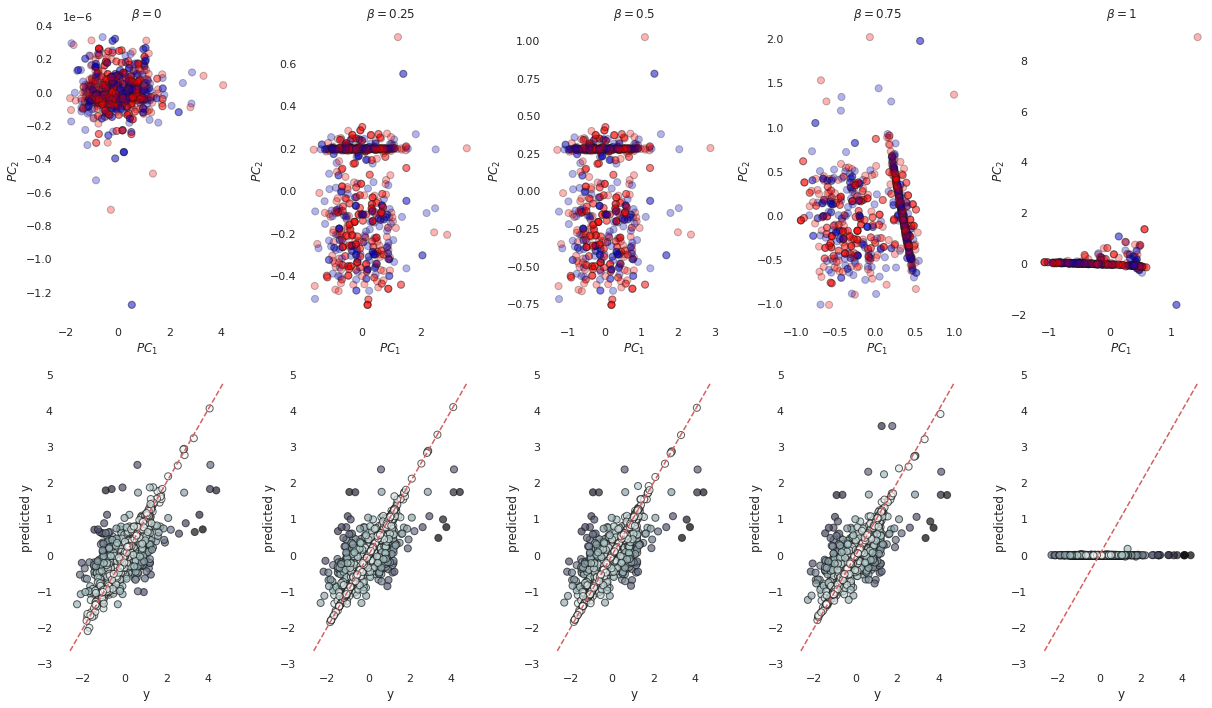

In [27]:

betas=[0,0.25, 0.5, 0.75, 1]

fig, axes = plt.subplots(2,5, figsize=(17,10))
sns.despine(left=True, bottom=True)

for i in range(len(betas)):
    
    pcovr = PCovR(mixing=betas[i],
              n_components=2)
    pcovr.fit(X,Y)
    T = pcovr.transform(X)
    yp = pcovr.predict(X)

    axes[0,i].scatter(T[:, 0], T[:, 1], s=50, alpha=0.3, c=y_atom, cmap = colors.ListedColormap(["mediumblue", 'red']), edgecolor="k")
    axes[0,i].set_xlabel(r"$PC_1$")
    axes[0,i].set_ylabel(r"$PC_2$")


    axes[1,i].scatter(Y, yp, s=50, alpha=0.7, c=np.abs(Y - yp), cmap='bone_r', edgecolor="k")
    axes[1,i].plot(axes[1,i].get_xlim(), axes[1,i].get_xlim(), 'r--')
    axes[1,i].set_xlabel(r"y")
    axes[1,i].set_ylabel(r"predicted y")


    axes[0,i].set_title(r"$\beta=$" + str(betas[i]))
    fig.tight_layout()

ENERGY DESCRIPTORS 

In [34]:
df.head()
e_form=df['e_form']
e_hull=df['e_hull']
e_gap=df['gap pbe']

<ipython-input-44-22e3cda21483>:38: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  cax = fig.add_axes()


R^2 with PCovR=  0.870068909062037
R^2 of testing is with RidgeCV -0.04085077255600922
RMSE on predicted quantity =  1.0113890357413051
error in units (eV) of predicted quantity before scaling =  [8.99145153]
error in units (eV) of predicted quantity after scaling=  [6.99441726]


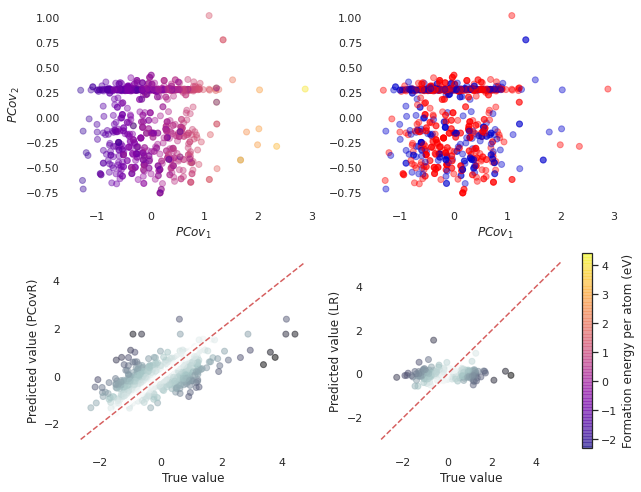

<ipython-input-44-22e3cda21483>:38: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  cax = fig.add_axes()


R^2 with PCovR=  0.8270650415486497
R^2 of testing is with RidgeCV -0.016058449063708125
RMSE on predicted quantity =  1.2727612444357757
error in units (eV) of predicted quantity before scaling =  [5.98710558]
error in units (eV) of predicted quantity after scaling=  [11.9874967]


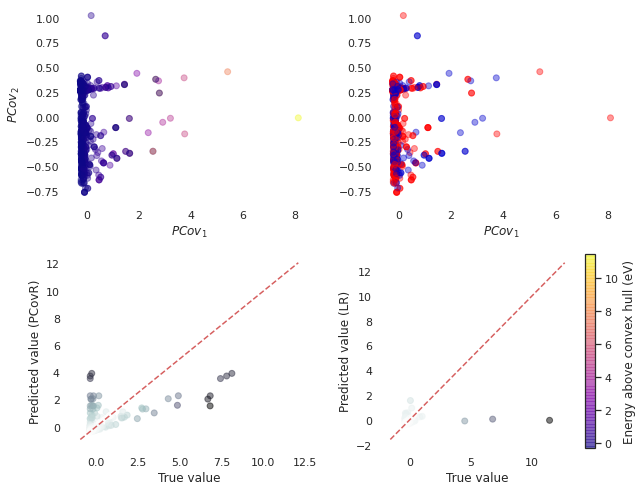

<ipython-input-44-22e3cda21483>:38: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  cax = fig.add_axes()


R^2 with PCovR=  0.8140058822748706
R^2 of testing is with RidgeCV -0.11265333971732305
RMSE on predicted quantity =  1.1110591810667139
error in units (eV) of predicted quantity before scaling =  [8.4744129]
error in units (eV) of predicted quantity after scaling=  [5.22626804]


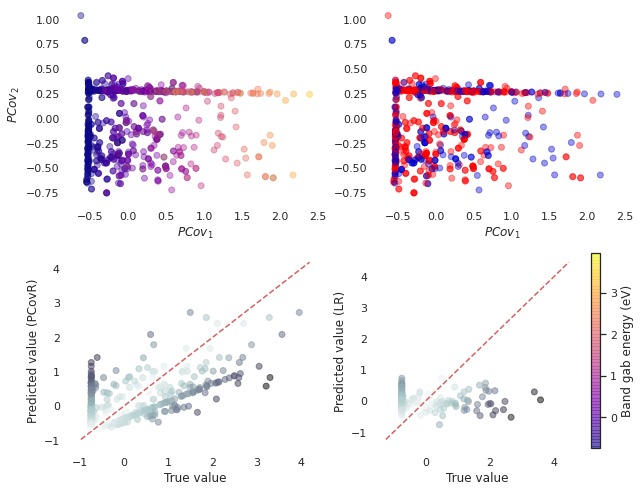

In [44]:
n_PC=5 #  number of principal covariates
titles=['Formation energy per atom (eV)', 'Energy above convex hull (eV)', 'Band gab energy (eV)']
quantity=[e_form, e_hull, e_gap]
for i in range(len(titles)):
    X=np.copy(X_raw)
    y_raw=np.array(quantity[i]).reshape(-1, 1)
    i_train, i_test, X_train, X_test, y_train, y_test = train_test_split(
    np.arange(X.shape[0]), X, y_raw, train_size=0.8
    )

    x_scaler = StandardFlexibleScaler(column_wise=False).fit(X)
    y_scaler = StandardFlexibleScaler(column_wise=True).fit(y_raw)

    # Center total dataset
    X = x_scaler.transform(X)
    Y = y_scaler.transform(y_raw)

    # Center training data
    X_train = x_scaler.transform(X_train)
    y_train = y_scaler.transform(y_train)

    # Center training data
    X_test = x_scaler.transform(X_test)
    y_test = y_scaler.transform(y_test)
    pcovr = PCovR(mixing=0.5,
              n_components=n_PC)
    pcovr.fit(X,Y)
    
    T = pcovr.transform(X)
    yp = pcovr.predict(X)
    
    ridgecv.fit(X_train, y_train)
    yp_test=ridgecv.predict(X_test)
#     fig, ((caxT, caxM),(axT, axM),  (axy, axy_reg), (caxy, caxy_reg)) = plt.subplots(
#         4, 2, figsize=(9,9), gridspec_kw=dict(height_ratios=(0.07, 1, 1, 0.07)))
    fig, ((axT, axM),  (axy, axy_reg)) = plt.subplots(
        2, 2, figsize=(9,7))
    cax = fig.add_axes()
    
    scatT = axT.scatter(T[:, 0], T[:, 1], alpha=0.4, c=Y, cmap='plasma')
    axT.set_xlabel(r"$PCov_1$")
    axT.set_ylabel(r"$PCov_2$")
    fig.colorbar(scatT, cax=cax, orientation='vertical', label=titles[i])

#     fig.colorbar(scatT, cax=caxT, label=titles[i], orientation="horizontal")

    scatM = axM.scatter(T[:, 0], T[:, 1], alpha=0.4, c=magic, cmap = my_c)
    axM.set_xlabel(r"$PCov_1$")
#     fig.colorbar(scatM, cax=caxM, label="magic=1", orientation="horizontal")

    scaty = axy.scatter(Y, yp, alpha=0.5, c=np.abs(Y - yp), cmap='bone_r')
    axy.plot(axy.get_xlim(), axy.get_xlim(), 'r--')
    axy.set_xlabel(r"True value")
    axy.set_ylabel(r"Predicted value (PCovR)")
#     fig.colorbar(scaty, cax=caxy,label='Error in y', orientation="horizontal")
    
    scaty_reg=axy_reg.scatter(y_test, yp_test, c=np.abs(y_test - yp_test), cmap="bone_r", alpha=0.5)    
    axy_reg.plot(axy.get_xlim(), axy.get_xlim(), 'r--')
    axy_reg.set_xlabel(r"True value")
    axy_reg.set_ylabel(r"Predicted value (LR)")
#     fig.colorbar(scaty_reg, cax=caxy_reg,label='Error in y', orientation="horizontal")
    
    fig.tight_layout()
    sns.despine(left=True, bottom=True)
    print('R^2 with PCovR= ', pcovr.score(X,Y))
    print('R^2 of testing is with RidgeCV', ridgecv.score(X_test,y_test))
    print("RMSE on predicted quantity = ", mean_squared_error(y_test, yp_test))
    print("error in units (eV) of predicted quantity before scaling = ", (max(y_raw)-min(y_raw))*(1-ridgecv.score(X_test,y_test)))
    print("error in units (eV) of predicted quantity after scaling= ", (max(Y)-min(Y))*(1-ridgecv.score(X_test,y_test)))

    plt.show()
    plt.close()